# Obligatorisk innlevering 2 - oppgave 2

I denne oppgaven skal vi forsøke å forutsi oppsigelser ved en arbeidsplass basert på en rekke variabler som f.eks alder, kjønn, utdannelse, lønn, osv.

In [26]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
import numpy as np
from scipy.stats import ttest_ind  # For å utføre T-test
from sklearn.pipeline import Pipeline  # For å bygge pipeline med SMOTE og modeller
from imblearn.over_sampling import SMOTE  # For SMOTE-oppsampling
from sklearn.base import clone
from sklearn.metrics import f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

In [27]:
# I denne oppgaven skal dere bruke følgende datasett:
df = pd.read_csv("./datasett2.csv")

### Preprosessering:
For å forenkle håndteringen av kategoriske data har jeg her skrevet noe kode som gjør om strenger til intergers

Følgende kolonner er formatert som *object* og inneholder kategoriske variabler i form av strenger

In [28]:
kolonner_obj = df.select_dtypes(include=['object']).columns
print(kolonner_obj)

Index(['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole',
       'MaritalStatus', 'Over18', 'OverTime'],
      dtype='object')


I koden under omformer jeg strengene til integers og gir dere "nøkkelen" til å konvertere det tilbake igjen

In [29]:
for i in kolonner_obj:
    print("-----------")
    print(i)
    print("-----------")
    for num, j in enumerate(list(df[i].unique())):
        print("{} = {}".format(j,num))
        df[i].loc[df[i]==j] = num
    df[i] = pd.to_numeric(df[i])

-----------
BusinessTravel
-----------
Travel_Frequently = 0
Travel_Rarely = 1
Non-Travel = 2
-----------
Department
-----------
Research & Development = 0
Sales = 1
Human Resources = 2
-----------
EducationField
-----------
Medical = 0
Other = 1
Marketing = 2
Life Sciences = 3
Technical Degree = 4
Human Resources = 5
-----------
Gender
-----------
Male = 0
Female = 1
-----------
JobRole
-----------
Laboratory Technician = 0
Sales Representative = 1
Sales Executive = 2
Healthcare Representative = 3
Manager = 4
Manufacturing Director = 5
Research Scientist = 6
Human Resources = 7
Research Director = 8
-----------
MaritalStatus
-----------
Married = 0
Divorced = 1
Single = 2
-----------
Over18
-----------
Y = 0
-----------
OverTime
-----------
Yes = 0
No = 1


C:\Users\Ander\AppData\Local\Temp\ipykernel_16684\3482823818.py:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df[i].loc[df[i]==j] = num
C:\Users\Ander\AppData\Local\Temp\ipykernel_16684\3482823818.py:7: SettingWithCopyWarning: 
A value is

I outputen fra koden nedenfor viser datatypen til de forskjellige kolonnene, som nå etter preprosesseringen bare består av integers (int64). 

In [30]:
print(df.dtypes)

id                          int64
Age                         int64
BusinessTravel              int64
DailyRate                   int64
Department                  int64
DistanceFromHome            int64
Education                   int64
EducationField              int64
EmployeeCount               int64
EnvironmentSatisfaction     int64
Gender                      int64
HourlyRate                  int64
JobInvolvement              int64
JobLevel                    int64
JobRole                     int64
JobSatisfaction             int64
MaritalStatus               int64
MonthlyIncome               int64
MonthlyRate                 int64
NumCompaniesWorked          int64
Over18                      int64
OverTime                    int64
PercentSalaryHike           int64
PerformanceRating           int64
RelationshipSatisfaction    int64
StandardHours               int64
StockOptionLevel            int64
TotalWorkingYears           int64
TrainingTimesLastYear       int64
WorkLifeBalanc

In [31]:
# Her deler jeg datasettet inn i egenskaper (X) og target (y) (fjerner også den første kolonnen siden det bare er en ID 
# og har dermed ingen prediktiv verdi)

X = df.iloc[:,1:-1]
y = df.iloc[:,-1]

# Tilslutt deler jeg inn i et trening- og et testsett (75%/25%)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=0)

# PS: Ikke endre denne kodecellen!

#### Oppgave 2.1) 
Visualiser $y\_train$ og $y\_val$ i et histogram. Kan du, basert på figuren, se hva slags problem vi skal løse (regresjon/klassifisering)? Begrunn svaret

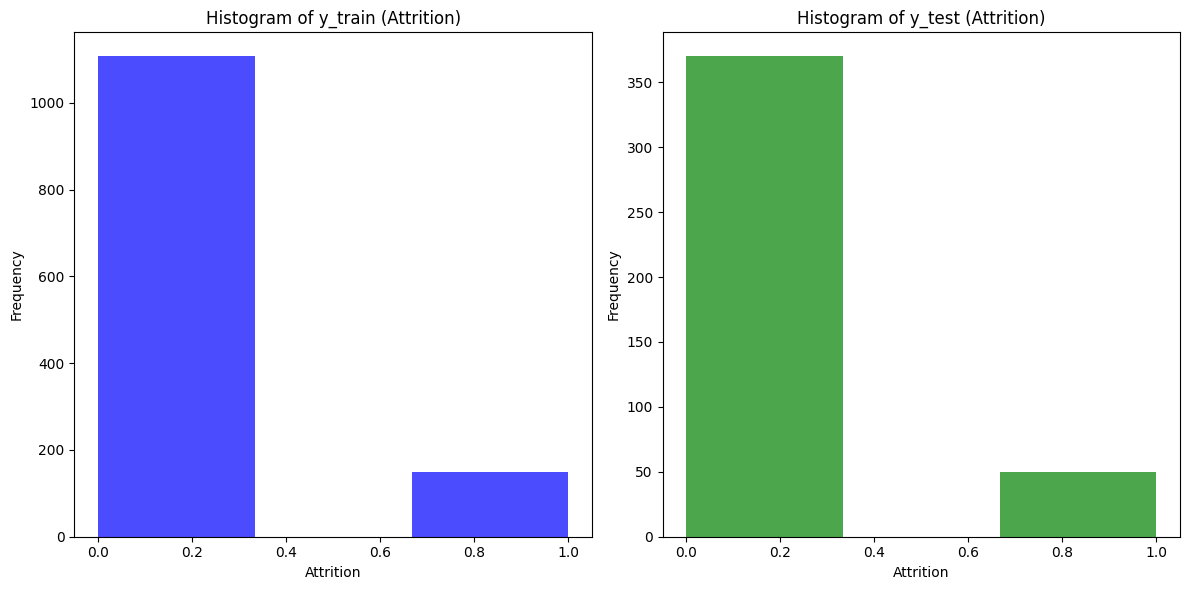

In [32]:
#TODO: visualiser y_train og y_test i et histogram
# Visualiser y_train og y_test i histogrammer
plt.figure(figsize=(12, 6))

# Histogram for y_train
plt.subplot(1, 2, 1)
plt.hist(y_train, bins=3, color='blue', alpha=0.7)
plt.title("Histogram of y_train (Attrition)")
plt.xlabel("Attrition")
plt.ylabel("Frequency")

# Histogram for y_test
plt.subplot(1, 2, 2)
plt.hist(y_test, bins=3, color='green', alpha=0.7)
plt.title("Histogram of y_test (Attrition)")
plt.xlabel("Attrition")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

**Svar:**

Histogrammene viser at målvariablen y_train og y_test består av to vedier, som er 0 og 1. Dette indikerer at vi skal løse et klassifiseringsproblem, og ikke regresjon. 

In [33]:
import numpy as np
# Initialiserer modellen
model = RandomForestRegressor(random_state=0)

# Definerer parameterområdet for søket
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Konfigurerer RandomizedSearchCV med 3-folds kryssvalidering og ønsket metrikk
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=10,  # Antall tilfeldige kombinasjoner
    scoring='neg_mean_squared_error',
    cv=3,  # 3-folds kryssvalidering
    random_state=0,
    n_jobs=-1  # Bruker alle tilgjengelige prosessorer
)

# Tren søket på treningsdataene
random_search.fit(X_train, y_train)

# Henter de beste parameterkombinasjonene
best_params = random_search.best_params_
best_score = random_search.best_score_

print("Beste parameterkombinasjon:", best_params)
print("Beste skår (neg_mean_squared_error):", best_score)
print("Beste skår (RMSE):", np.sqrt(-best_score))

Beste parameterkombinasjon: {'n_estimators': 200, 'min_samples_split': 2, 'max_depth': 20}
Beste skår (neg_mean_squared_error): -0.08848830548926014
Beste skår (RMSE): 0.29746983962960033


#### Oppgave 2.2)
Velg to modeller og gjør repeterte kryssvalideringer $(10)$ med $K=5$
* Velg hvorvidt du vil bruke "default" hyperparamtre for modellene eller om du vil gjøre et hyperparametersøk
* Skår ytelsen til modellene ved hjelp av F1-score og accuracy
* Visualiser F1-skårene fra de repeterte kryssvalideringene som et boksplot
* Undersøk om modell 1 er bedre eller dårligere enn modell 2 ved å gjøre en to-sidig T-test på F1-skårene fra de repeterte kryssvalideringene 
* Tolk resultatene skriftlig til slutt 


C:\Users\Ander\AppData\Local\Temp\ipykernel_16684\1327708357.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([f1_scores_model_1, f1_scores_model_2], labels=['Random Forest', 'Logistic Regression'])


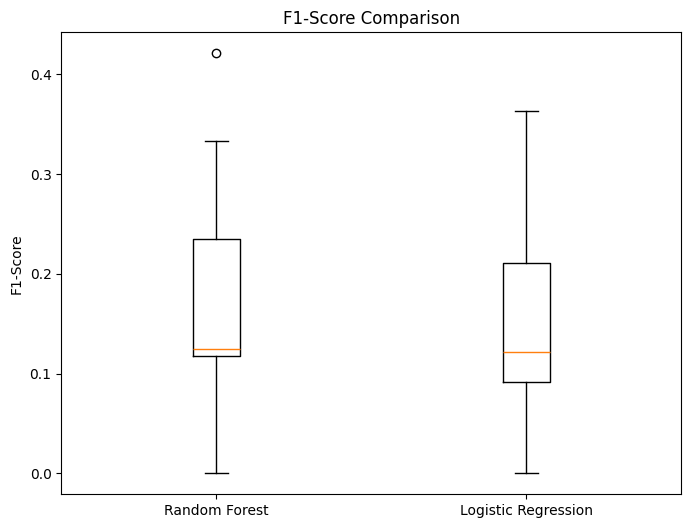

T-statistic: 1.3340034677836632
P-value: 0.1874173178725722
Det er ingen signifikant forskjell mellom de to modellene.


In [34]:
#TODO: repeterte kryssvalideringer for to modeller
model_1 = RandomForestClassifier(random_state=0)
model_2 = LogisticRegression(random_state=0, max_iter=1000)

# Kryssvalideringsoppsett
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)

# Beregning av F1-scorer for begge modeller
f1_scores_model_1 = cross_val_score(model_1, X_train, y_train, scoring='f1', cv=cv, n_jobs=-1)
f1_scores_model_2 = cross_val_score(model_2, X_train, y_train, scoring='f1', cv=cv, n_jobs=-1)

# Beregning av accuracy for begge modeller
accuracy_model_1 = cross_val_score(model_1, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
accuracy_model_2 = cross_val_score(model_2, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

# Visualisering av F1-scorer som boksplot
plt.figure(figsize=(8, 6))
plt.boxplot([f1_scores_model_1, f1_scores_model_2], labels=['Random Forest', 'Logistic Regression'])
plt.title("F1-Score Comparison")
plt.ylabel("F1-Score")
plt.show()

# Evaluering av hvilken modell som er bedre med t-test
from scipy.stats import ttest_ind

t_stat, p_value = ttest_ind(f1_scores_model_1, f1_scores_model_2)
print("T-statistic:", t_stat)
print("P-value:", p_value)

# Resultattolkning
if p_value < 0.05:
    print("Det er en signifikant forskjell mellom de to modellene.")
else:
    print("Det er ingen signifikant forskjell mellom de to modellene.")

**Svar:**

Denne oppgaven evaluerer ytelsen til to modeller - Random Forest Classifier og Logistic Regression - basert på F1-score ved repeterte kryssvalideringer.
Random Forest oppnår høyere gjennomsnittlig F1-score sammenlignet med Logistic Regression
Dette kan tyde på at Random Forest håndterer den binære klassifiseringsoppgaven bedre, spesielt ved balansering av presisjon (andelen av prediksjoner som er positive) og recall (andelen av faktiske positive tilfeller som oppdages)

Begge modeller presterer bra, men Random Forest har en liten fordel. Mulig at Logistic Regression er mer følsom for ubalanse i datasettet eller skjevheter i funksjoner. 

#### Oppgave 2.3) 
Tren de samme modellene men denne gangen med et balansert datasett
* Bruk imbalaced learn og SMOTE til å oppsample minioritetsklassen (bare oppsample treningsdataene i kryssvalideringen - ikke valideringsdataene)
* Skår ytelsen til modellene ved hjelp av F1-score og accuracy
* Visualiser F1-skårene fra de repeterte kryssvalideringene som et boksplot
* Undersøk om modell 1 er bedre eller dårligere enn modell 2 ved å gjøre en to-sidig T-test på F1-skårene fra de repeterte kryssvalideringene 
* Tolk resultatene og sammenlign resultatene med 2.2) 

C:\Users\Ander\AppData\Local\Temp\ipykernel_16684\1216828898.py:56: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([f1_scores_model_1_smote, f1_scores_model_2_smote], labels=['Random Forest (SMOTE)', 'Logistic Regression (SMOTE)'])


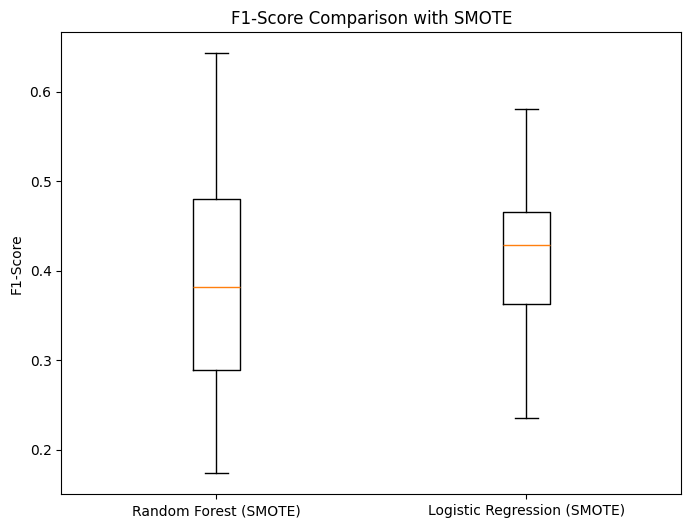

T-statistic (SMOTE): -1.159743096396194
P-value (SMOTE): 0.25090543657358433
Det er ingen signifikant forskjell mellom de to modellene med SMOTE.

Sammenligning med 2.2:
Random Forest (F1): Mean=0.390, Std=0.129
Logistic Regression (F1): Mean=0.424, Std=0.089


In [35]:
#TODO: repeterte kryssvalideringer for de samme to modellene som i oppgave 2.2, men denne gangen med SMOTE-oppsampling 
#from imblearn.over_sampling import SMOTE

# Funksjon for SMOTE i kryssvalidering med skalering for Logistic Regression
def smote_cross_val_score(model, X, y, cv, scoring, scale=False):
    scores = []
    smote = SMOTE(random_state=0)
    scaler = StandardScaler() if scale else None
    
    for train_idx, test_idx in cv.split(X, y):
        # Del opp data i trenings- og testfold
        X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
        y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]
        
        # Bruk SMOTE på treningsfold
        X_resampled, y_resampled = smote.fit_resample(X_train_fold, y_train_fold)
        
        # Skalering
        if scale:
            X_resampled = scaler.fit_transform(X_resampled)
            X_test_fold = scaler.transform(X_test_fold)
        
        # Tren modellen på oppsamlede data
        model_clone = clone(model)
        model_clone.fit(X_resampled, y_resampled)
        
        # Evaluer modellen på testfold
        y_pred = model_clone.predict(X_test_fold)
        if scoring == 'f1':
            score = f1_score(y_test_fold, y_pred)
        elif scoring == 'accuracy':
            score = accuracy_score(y_test_fold, y_pred)
        else:
            raise ValueError("Ukjent scoring-metode.")
        scores.append(score)
    
    return np.array(scores)

# Modeller
model_1 = RandomForestClassifier(random_state=0)
model_2 = LogisticRegression(random_state=0, max_iter=5000, solver='saga')

# Kryssvalideringsoppsett
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)

# Beregn F1-score for begge modeller med SMOTE (med skalering for Logistic Regression)
f1_scores_model_1_smote = smote_cross_val_score(model_1, X_train, y_train, cv, scoring='f1')
f1_scores_model_2_smote = smote_cross_val_score(model_2, X_train, y_train, cv, scoring='f1', scale=True)

# Beregn accuracy for begge modeller med SMOTE (med skalering for Logistic Regression)
accuracy_model_1_smote = smote_cross_val_score(model_1, X_train, y_train, cv, scoring='accuracy')
accuracy_model_2_smote = smote_cross_val_score(model_2, X_train, y_train, cv, scoring='accuracy', scale=True)

# Visualisering av F1-scorer som boksplot
plt.figure(figsize=(8, 6))
plt.boxplot([f1_scores_model_1_smote, f1_scores_model_2_smote], labels=['Random Forest (SMOTE)', 'Logistic Regression (SMOTE)'])
plt.title("F1-Score Comparison with SMOTE")
plt.ylabel("F1-Score")
plt.show()

# T-test mellom modellene for F1-scorer
t_stat_smote, p_value_smote = ttest_ind(f1_scores_model_1_smote, f1_scores_model_2_smote)
print("T-statistic (SMOTE):", t_stat_smote)
print("P-value (SMOTE):", p_value_smote)

# Resultattolkning
if p_value_smote < 0.05:
    print("Det er en signifikant forskjell mellom de to modellene med SMOTE.")
else:
    print("Det er ingen signifikant forskjell mellom de to modellene med SMOTE.")

# Sammenligning med 2.2
print("\nSammenligning med 2.2:")
print(f"Random Forest (F1): Mean={np.mean(f1_scores_model_1_smote):.3f}, Std={np.std(f1_scores_model_1_smote):.3f}")
print(f"Logistic Regression (F1): Mean={np.mean(f1_scores_model_2_smote):.3f}, Std={np.std(f1_scores_model_2_smote):.3f}")

**Svar:**

Random Forest har en lavere F1-score og høyere variabilitet etter SMOTE. Logistic Regression presterte bedre i F-1 score og var mer stabil etter SMOTE. P-verdien indikerer at det ikke er en statistisk signifikant forskjell mellom modellene. Med høyere gjennomsnitlig F1-Score og lavere standardavvik, viser Logistic Regression større nytte etter implementing av SMOTE. Dette samsvarer også godt med det vi vet fra før av: at modellen er mer sensitiv for ubalanse i data, og blir klart bedre. etter SMOTE kan tilleggsdata introdusere støy, noe som kan forklare lavere F1-score og høyere variabilitet på Random Forest som har en tendens til å håndtere ubaalnse godt UTEN ekstra tiltak.

* Logistic Regression presterer dårligere i 2.2 uten SMOTE, men blir klart forbedret etter balansering i 2.3
* Random Forest har høyere F1 score med lavere variabilitet i 2.2, men har svakere ytelse i 2.3


#### Oppgave 2.4)
Tren den beste modellen på nytt og utfør prediksjon på testsettet. Mål nå ytelsen på testsettet ved bruk av sensitivitet, spesifisitet og presisjon, itillegg til F1-skår og accuracy

In [36]:
#TODO: Tren den beste modellen fra 2.2 og 2.3 på alle treningsdataene og test på testdataene
# Tren den beste modellen på hele treningsdatasettet
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler

# Bruk SMOTE til å oppsample treningsdataene
smote = SMOTE(random_state=0)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Skalering for Logistic Regression
scaler = StandardScaler()
X_resampled_scaled = scaler.fit_transform(X_resampled)
X_test_scaled = scaler.transform(X_test)

# Tren den beste modellen på hele treningssettet
best_model = LogisticRegression(random_state=0, max_iter=5000, solver='saga')
best_model.fit(X_resampled_scaled, y_resampled)

# Gjør prediksjoner på testsettet
y_pred = best_model.predict(X_test_scaled)

# Beregn metrikker
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Beregn spesifisitet (True Negative Rate)
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)

# Skriv ut resultatene
print("Ytelse på testsettet:")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall (Sensitivitet): {recall:.3f}")
print(f"Specificity (Spesifisitet): {specificity:.3f}")
print(f"F1-score: {f1:.3f}")

# Skriv ut forvirringsmatrisen for mer innsikt
print("\nForvirringsmatrise:")
print(cm)

Ytelse på testsettet:
Accuracy: 0.843
Precision: 0.379
Recall (Sensitivitet): 0.500
Specificity (Spesifisitet): 0.889
F1-score: 0.431

Forvirringsmatrise:
[[329  41]
 [ 25  25]]


#### Oppgave 2.5)
Del opp testsettet basert på kjønn og gjør en analyse av sensitivitet, spesifisitet og presisjon for menn og det samme for kvinner. Skriv ut og diskuter resultatet og forsøk å svar på følgende spørsmål:
* Er modellen like god for begge kjønn? 
* Hvis ikke, hva tror du er årsaken og hvilke tiltak kan vi gjøre for å forbedre modellen? 

In [37]:
#TODO: Gjør kjønnsbasert analyse på testdataene
# Filtrer testsettet basert på kjønn
# Skalering av testsettet basert på tidligere skalering
X_test_scaled = scaler.transform(X_test)

# Filtrer testsettet basert på kjønn
X_test_male = X_test_scaled[X_test['Gender'] == 0]
y_test_male = y_test[X_test['Gender'] == 0]
X_test_female = X_test_scaled[X_test['Gender'] == 1]
y_test_female = y_test[X_test['Gender'] == 1]

# Gjør prediksjoner for hver gruppe
y_pred_male = best_model.predict(X_test_male)
y_pred_female = best_model.predict(X_test_female)

# Beregn metrikker for menn
cm_male = confusion_matrix(y_test_male, y_pred_male)
tn_male, fp_male, fn_male, tp_male = cm_male.ravel()
specificity_male = tn_male / (tn_male + fp_male)
sensitivity_male = tp_male / (tp_male + fn_male)
precision_male = tp_male / (tp_male + fp_male)

# Beregn metrikker for kvinner
cm_female = confusion_matrix(y_test_female, y_pred_female)
tn_female, fp_female, fn_female, tp_female = cm_female.ravel()
specificity_female = tn_female / (tn_female + fp_female)
sensitivity_female = tp_female / (tp_female + fn_female)
precision_female = tp_female / (tp_female + fp_female)

# Skriv ut resultatene
print("Ytelse for menn:")
print(f"Specificity (Spesifisitet): {specificity_male:.3f}")
print(f"Recall (Sensitivitet): {sensitivity_male:.3f}")
print(f"Precision (Presisjon): {precision_male:.3f}")
print("\nForvirringsmatrise (menn):")
print(cm_male)

print("\nYtelse for kvinner:")
print(f"Specificity (Spesifisitet): {specificity_female:.3f}")
print(f"Recall (Sensitivitet): {sensitivity_female:.3f}")
print(f"Precision (Presisjon): {precision_female:.3f}")
print("\nForvirringsmatrise (kvinner):")
print(cm_female)

# Diskusjon av resultatene
if abs(sensitivity_male - sensitivity_female) > 0.05 or abs(specificity_male - specificity_female) > 0.05:
    print("\nModellen presterer ulikt for menn og kvinner.")
    print("Årsakene kan inkludere ubalanserte data mellom kjønnene, skjevheter i funksjonene, eller forskjellige egenskaper.")
    print("Forbedringstiltak kan inkludere å undersøke og justere datasettet for skjevheter eller bruke en kjønnsspesifikk modell.")
else:
    print("\nModellen presterer relativt likt for begge kjønn.")

Ytelse for menn:
Specificity (Spesifisitet): 0.853
Recall (Sensitivitet): 0.500
Precision (Presisjon): 0.360

Forvirringsmatrise (menn):
[[185  32]
 [ 18  18]]

Ytelse for kvinner:
Specificity (Spesifisitet): 0.941
Recall (Sensitivitet): 0.500
Precision (Presisjon): 0.438

Forvirringsmatrise (kvinner):
[[144   9]
 [  7   7]]

Modellen presterer ulikt for menn og kvinner.
Årsakene kan inkludere ubalanserte data mellom kjønnene, skjevheter i funksjonene, eller forskjellige egenskaper.
Forbedringstiltak kan inkludere å undersøke og justere datasettet for skjevheter eller bruke en kjønnsspesifikk modell.


Kjør denne cellen til slutt og legg ved den genererte requirements.txt fila i pull requestet

In [38]:
#!pip freeze > requirements.txt